<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Sentiment analysis con Embeddings + LSTM

### Objetivo
El objetivo es utilizar las críticas de compradores de ropa para que el sistema determine la evaluación del comprador y su crítica (cuantas estrellas le asigna al producto).

In [2]:
import numpy as np
import random
import io
import pickle
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding
from keras.callbacks import EarlyStopping

### Datos
Utilizaremos como dataset críticas de compradores de ropa (eCommerce) los cuales puntuaron a cada prenda con un puntaje de 1 a 5 estrellas.\
Referencia del dataset: [LINK](https://www.kaggle.com/nicapotato/womens-ecommerce-clothing-reviews/version/1)

In [3]:
# Armar el dataset
df = pd.read_csv('clothing_ecommerce_reviews.csv')
df.drop(columns = ['Unnamed: 0'], inplace = True)
df.head()

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


### 1 - Limpieza de datos
Alumno:
- Del dataset unicamente utilizar las columnas "Review Text" y "Rating.
- Tranformar el rating 1-5 a una escala numérica de 0 a 4.



In [4]:
df_reviews = df.loc[:, ['Review Text', 'Rating']].dropna()
df_reviews['Rating'] = df_reviews['Rating'] - 1
df_reviews.head()

,Review Text,Rating
0,Absolutely wonderful - silky and sexy and comf...,3
1,Love this dress! it's sooo pretty. i happene...,4
2,I had such high hopes for this dress and reall...,2
3,"I love, love, love this jumpsuit. it's fun, fl...",4
4,This shirt is very flattering to all due to th...,4


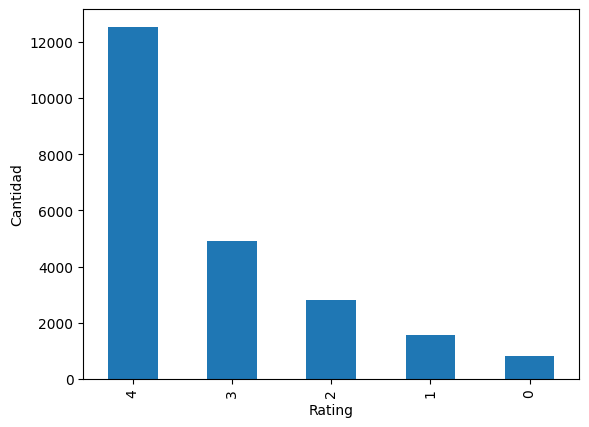

In [4]:
# Alumno: Observar como está distribuido el dataset respecto a la columna Rating
# es decir, observar que tan balanceado se encuentra respecot a cada clase
df_reviews["Rating"].value_counts().plot(kind="bar")
plt.xlabel("Rating"), plt.ylabel("Cantidad")
plt.show()

In [5]:
# Alumno: tomar la columna de las review y almacenarlo todo en un vector numpy de reviews
vec_reviews = np.array(df_reviews['Review Text'].values)

In [6]:
# Alumno: Cuantas reviews (rows) hay para evaluar?
vec_reviews.size

22641

In [7]:
# Alumno: Concatenar todas las reviews para armar el corpus
corpus = ' '.join(vec_reviews)
corpus[:3000]

'Absolutely wonderful - silky and sexy and comfortable Love this dress!  it\'s sooo pretty.  i happened to find it in a store, and i\'m glad i did bc i never would have ordered it online bc it\'s petite.  i bought a petite and am 5\'8".  i love the length on me- hits just a little below the knee.  would definitely be a true midi on someone who is truly petite. I had such high hopes for this dress and really wanted it to work for me. i initially ordered the petite small (my usual size) but i found this to be outrageously small. so small in fact that i could not zip it up! i reordered it in petite medium, which was just ok. overall, the top half was comfortable and fit nicely, but the bottom half had a very tight under layer and several somewhat cheap (net) over layers. imo, a major design flaw was the net over layer sewn directly into the zipper - it c I love, love, love this jumpsuit. it\'s fun, flirty, and fabulous! every time i wear it, i get nothing but great compliments! This shirt

In [8]:
# Alumno: ¿Cuál es la longitud de ese corpus?
len(corpus)

7011643

In [9]:
# Alumno: Utilizar "text_to_word_sequence" para separar las palabras en tokens
# recordar que text_to_word_sequence automaticamente quita los signos de puntuacion y pasa el texto a lowercase
from keras.preprocessing.text import text_to_word_sequence

tokens = text_to_word_sequence(corpus)

In [10]:
# Alumno: Dar un vistazo a los primeros 20 tokens/palabras
tokens[:20]

['absolutely',
 'wonderful',
 'silky',
 'and',
 'sexy',
 'and',
 'comfortable',
 'love',
 'this',
 'dress',
 "it's",
 'sooo',
 'pretty',
 'i',
 'happened',
 'to',
 'find',
 'it',
 'in',
 'a']

In [11]:
# Alumno: ¿Cuántos tokens/palabras hay?
len(tokens)

1372203

In [12]:
# Alumno: Tokenizar las palabras con el Tokenizer de Keras
# Definir una máxima cantidad de palabras a utilizar:
# num_words --> the maximum number of words to keep, based on word frequency.
# Only the most common num_words-1 words will be kept.
from keras.preprocessing.text import Tokenizer
num_words = 2000
vocab_size = num_words

tok = Tokenizer(num_words=vocab_size)
tok.fit_on_texts(tokens)

In [13]:
# Alumno: Obtener el diccionario de palabra (word) a índice
# y observar la cantidad total del vocabulario
len(tok.word_index)

14847

In [14]:
# Alumno: Convertir las palabras/tokens a números
sequences = tok.texts_to_sequences(vec_reviews)

In [15]:
# Alumno: Determinar cual es la oración más larga
maxlen = max([len(x) for x in sequences])
maxlen

115

In [16]:
# Alumno: Realizar padding de las sentencias al mismo tamaño
# tomando de referencia la máxima sentencia
from tensorflow.keras.utils import pad_sequences
padded = pad_sequences(sequences, padding='pre', maxlen=maxlen)

In [17]:
# Alumno: Observar las dimensiones de la variable input
padded.shape

(22641, 115)

In [18]:
# Alumno tomar la columna rating y alcemacenarla en una variable "y" transformada a oneHotEncoding
# Su shape debe ser equivalente la cantidad de rows del corpus y a la cantidad
# de clases que se deseen predecir (en este ejemplo son 5)
y = df_reviews["Rating"]
y = to_categorical(y, num_classes=5)
y.shape

(22641, 5)

In [19]:
# Alumno: Dividir los datos en train y test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(padded, y, test_size=0.2, random_state=10, stratify=y)

In [20]:
# Alumno: determinar la dimensiones de entrada y salida
print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("X_test:", X_test.shape)
print("y_test:", y_test.shape)
print()
print("Dimensión de entrada:", X_train.shape[1])
print("Dimensión de salida:", y.shape[1])

X_train: (18112, 115)
y_train: (18112, 5)
X_test: (4529, 115)
y_test: (4529, 5)

Dimensión de entrada: 115
Dimensión de salida: 5


In [21]:
vocab_size+1

2001

### 2 - Entrenar el modelo con Embeddings + LSTM

In [33]:
# Alumno: Entrene su modelo con LSTM entrenando sus propios embeddings
# o utilizando embeddings pre-entrenados.
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout
from keras.layers import Bidirectional

model = Sequential()

model.add(Embedding(input_dim=vocab_size+1, output_dim=40, input_length=X_train.shape[1]))

model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(Dropout(0.2))

model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(Dropout(0.3))
model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.2))

model.add(Bidirectional(LSTM(64)))

# Capas densas
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))

# Capa de salida
model.add(Dense(y.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()



Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 115, 40)           80040     
                                                                 
 bidirectional_6 (Bidirecti  (None, 115, 256)          173056    
 onal)                                                           
                                                                 
 dropout_8 (Dropout)         (None, 115, 256)          0         
                                                                 
 bidirectional_7 (Bidirecti  (None, 115, 128)          164352    
 onal)                                                           
                                                                 
 dropout_9 (Dropout)         (None, 115, 128)          0         
                                                                 
 lstm_10 (LSTM)              (None, 115, 64)          

### Balanceo de datos:

Tal como vimos al inicio, la data está desbalanceada, no tenemos una distribución equitativa en los Ratings:

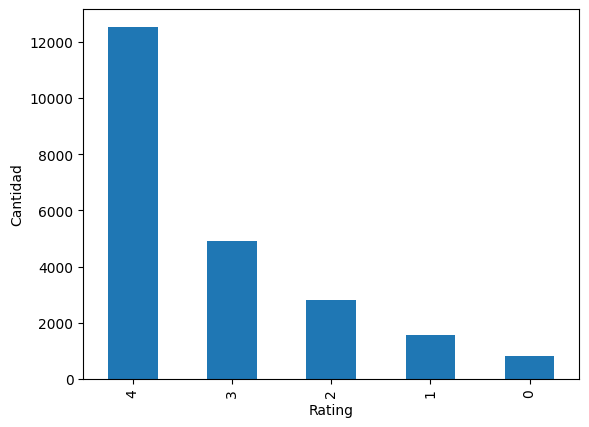

In [5]:
df_reviews["Rating"].value_counts().plot(kind="bar")
plt.xlabel("Rating"), plt.ylabel("Cantidad")
plt.show()

Vamos primero a entrenar el modelo con la data desbalanceada original:

In [24]:
early_stop = EarlyStopping(
    monitor='accuracy',
    patience=5,
    verbose=1,
    restore_best_weights=True
)

modelo = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=40, callbacks=[early_stop])

Epoch 1/40
566/566 [==============================] - 53s 93ms/step - loss: 1.0307 - accuracy: 0.5936 - val_loss: 0.9386 - val_accuracy: 0.6090
Epoch 2/40
566/566 [==============================] - 23s 41ms/step - loss: 0.8989 - accuracy: 0.6292 - val_loss: 0.9192 - val_accuracy: 0.6213
Epoch 3/40
566/566 [==============================] - 22s 39ms/step - loss: 0.8617 - accuracy: 0.6400 - val_loss: 0.9178 - val_accuracy: 0.6138
Epoch 4/40
566/566 [==============================] - 22s 38ms/step - loss: 0.8229 - accuracy: 0.6524 - val_loss: 0.9123 - val_accuracy: 0.6185
Epoch 5/40
566/566 [==============================] - 21s 38ms/step - loss: 0.7943 - accuracy: 0.6623 - val_loss: 0.9346 - val_accuracy: 0.6134
Epoch 6/40
566/566 [==============================] - 24s 42ms/step - loss: 0.7824 - accuracy: 0.6661 - val_loss: 0.9154 - val_accuracy: 0.5977
Epoch 7/40
566/566 [==============================] - 22s 39ms/step - loss: 0.7538 - accuracy: 0.6740 - val_loss: 0.9386 - val_accuracy:

Obtenemos el siguiente resultado:

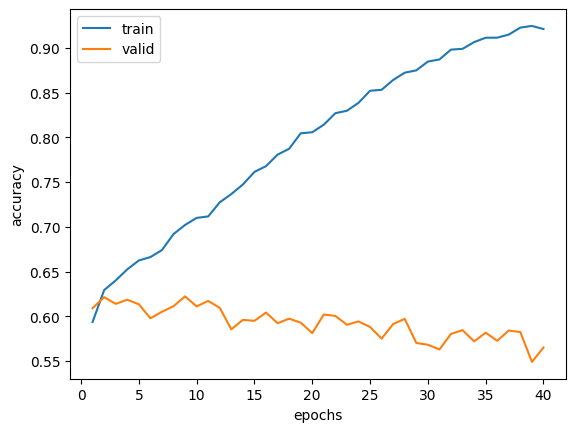

In [25]:
epoch_count = range(1, len(modelo.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=modelo.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=modelo.history['val_accuracy'], label='valid')
plt.xlabel("epochs"), plt.ylabel("accuracy")
plt.show()

Ahora vamos a balancear los datos. Se va usar el método "SMOTE" en vez de otro método más simple como lo sería "Random Over Sample". Ya que SMOTE en lugar de simplemente replicar muestras existentes, genera muestras sintéticas. Lo hace seleccionando dos o más muestras similares de la clase minoritaria y, luego, crea una nueva muestra que es una combinación lineal de las características de estas muestras. Esencialmente, SMOTE "interpola" entre varias muestras de la clase minoritaria para crear nuevas muestras sintéticas. Esto evita el overfitting.

In [31]:
from imblearn.over_sampling import SMOTE

smote = SMOTE()
X_train_SMOTE, y_train_SMOTE = smote.fit_resample(X_train, y_train)

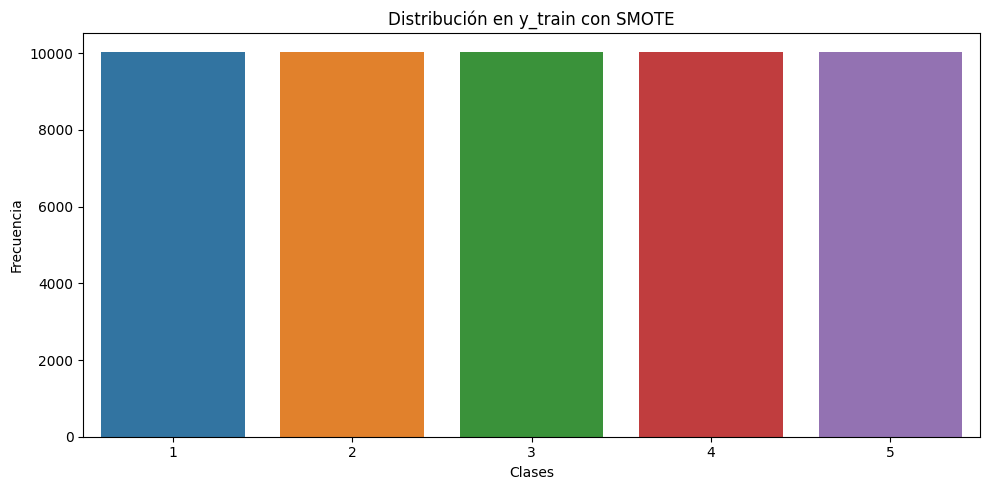

In [32]:
class_labels = [f'{i+1}' for i in range(y_train_SMOTE.shape[1])]
class_counts_train = y_train_SMOTE.sum(axis=0)

plt.figure(figsize=(10, 5))
sns.barplot(x=class_labels, y=class_counts_train)
plt.title(f'Distribución en y_train con SMOTE')
plt.ylabel('Frecuencia')
plt.xlabel('Clases')

plt.tight_layout()
plt.show()


In [29]:
modelo_smote = model.fit(X_train_SMOTE, y_train_SMOTE, validation_data=(X_test, y_test), epochs=40, callbacks=[early_stop])

Epoch 1/40
1568/1568 [==============================] - 95s 53ms/step - loss: 1.1798 - accuracy: 0.4557 - val_loss: 1.2944 - val_accuracy: 0.4003
Epoch 2/40
1568/1568 [==============================] - 56s 36ms/step - loss: 0.8750 - accuracy: 0.6289 - val_loss: 1.1304 - val_accuracy: 0.5507
Epoch 3/40
1568/1568 [==============================] - 53s 34ms/step - loss: 0.6995 - accuracy: 0.7199 - val_loss: 1.2379 - val_accuracy: 0.5564
Epoch 4/40
1568/1568 [==============================] - 53s 34ms/step - loss: 0.5973 - accuracy: 0.7654 - val_loss: 1.2596 - val_accuracy: 0.5558
Epoch 5/40
1568/1568 [==============================] - 54s 35ms/step - loss: 0.5160 - accuracy: 0.8016 - val_loss: 1.3385 - val_accuracy: 0.5354
Epoch 6/40
1568/1568 [==============================] - 55s 35ms/step - loss: 0.4535 - accuracy: 0.8280 - val_loss: 1.4501 - val_accuracy: 0.5295
Epoch 7/40
1568/1568 [==============================] - 55s 35ms/step - loss: 0.4046 - accuracy: 0.8467 - val_loss: 1.4514 -

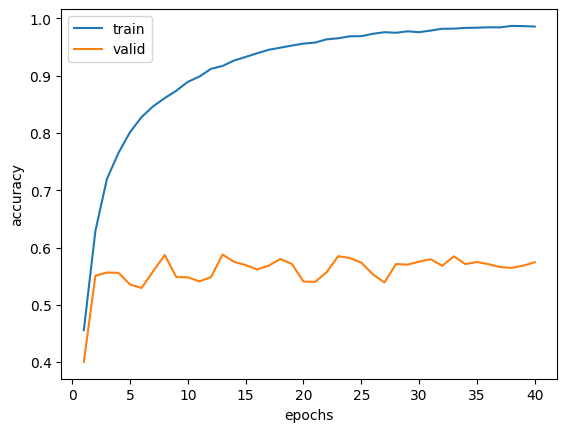

In [30]:
epoch_count = range(1, len(modelo_smote.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=modelo_smote.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=modelo_smote.history['val_accuracy'], label='valid')
plt.xlabel("epochs"), plt.ylabel("accuracy")
plt.show()

### Conclusión:

En el primer caso, donde usamos la data original, aunque la precisión del entrenamiento aumenta, la precisión de validación parece estancarse e incluso disminuir. Esto sugiere que el modelo podría estar sobreajustándose a la clase mayoritaria, ya que aprende a reconocerla muy bien pero tiene dificultades con la clase minoritaria.

En el segundo caso, donde usamos SMOTE, la precisión del entrenamiento también aumenta, pero notamos que la precisión de validación es más estable. Aunque todavía podría haber cierto sobreajuste, el modelo parece ser más robusto que el entrenado con datos desbalanceados.

Por ende, en contextos de datos desbalanceados, el uso de técnicas como SMOTE puede ofrecer modelos más robustos y con un rendimiento más equilibrado entre clases.